In [68]:
from datetime import datetime
from pathlib import Path
root = Path().cwd()

import numpy as np
import xarray as xr

from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.ticker as ticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import coordinate_utils as cu
import vec_transform as vt
import trend_utils as tu

import pickle

In [87]:
#Domains
norcal_domain = [-124.55, -117.25, 35.35, 42.45]
synoptic_domain = [-150, -90, 20, 60]

In [88]:
with open(root/'clusters.pkl', 'rb') as f:
    clusters = pickle.load(f)

In [89]:
lonlon_syn, latlat_syn = np.meshgrid(clusters["coords"]["lon_syn"], clusters["coords"]["lat_syn"],)
lonlon_frp, latlat_frp = np.meshgrid(clusters["coords"]['lon_frp'], clusters["coords"]['lat_frp'])

In [90]:
clusters['k'][0].keys()

dict_keys(['center', 'full', 'n_cases', 'times', 'frp', 'area_average_frp'])

In [73]:
i=0

Text(0.5, 1.0, '500 hPa Geopotental Height (filled contour)\nMean Sea Level Pressure (lined contour)\n2019-10-28T00Z')

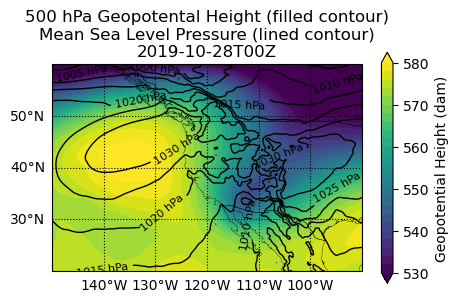

In [100]:
k=0
time = cu.ts_to_dt('2020-10-27')

z500min = 530
z500max = 580

mslpmin = 1000
mslpmax = 1030

fields = clusters["k"][k]["full"]
fig = plt.figure(figsize = (5,3))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.axis('scaled')
ax.add_feature(cfeature.NaturalEarthFeature(category='cultural', name='admin_0_countries', scale='50m'), linewidth=0.25, facecolor='none', edgecolor='black', zorder=2)
ax.set_extent(synoptic_domain, crs=ccrs.PlateCarree())

hgt_cont = ax.contourf(lonlon_syn, latlat_syn, fields.sel(valid_time=time)['z']/100, range(z500min, z500max+1, 2), extend='both')
cb = fig.colorbar(hgt_cont, ticks = range(z500min, z500max+1, 10), extend='both')
cb.update_ticks()
cb.set_label("Geopotential Height (dam)")

mslp_cont = ax.contour(lonlon_syn, latlat_syn, fields.sel(valid_time=time)['msl']/100, range(mslpmin, mslpmax+1, 5), linewidths=1, colors='black')
ax.clabel(mslp_cont, range(mslpmin, mslpmax+1, 5), inline=True, fmt = lambda x: f"{round(x)} hPa", fontsize=8)

gl_interval = 10
gl = ax.gridlines(color="black", linestyle="dotted", draw_labels=True, x_inline=False, y_inline=False)
gl.xlocator = plt.MultipleLocator(gl_interval)
gl.ylocator = plt.MultipleLocator(gl_interval)
gl.right_labels=False
gl.top_labels=False
gl.rotate_labels=False

plt.title("500 hPa Geopotental Height (filled contour)\nMean Sea Level Pressure (lined contour)\n2019-10-28T00Z")

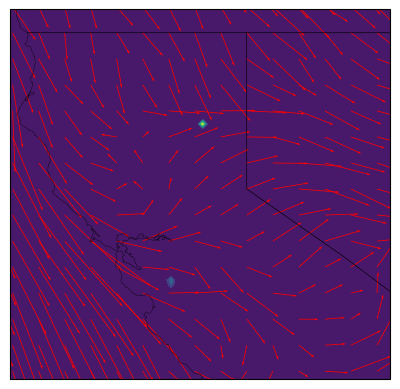

In [8]:
lonlon_frp, latlat_frp = np.meshgrid(clusters["coords"]['lon_frp'], clusters["coords"]['lat_frp'])
ax = plt.axes(projection=ccrs.PlateCarree())
plt.contourf(lonlon_frp, latlat_frp, clusters["k"][k]["frp"][i], transform=ccrs.PlateCarree())
ax.add_feature(cfeature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces', scale='10m'), linewidth=0.25, facecolor='none', edgecolor='black', zorder=2)

interval = 2

plt.quiver(lonlon_syn[::interval,::interval], latlat_syn[::interval,::interval], 
    fields.sel(valid_time=time)['u10'][::interval, ::interval], fields.sel(valid_time=time)['v10'][::interval, ::interval], 
    transform=ccrs.PlateCarree(), color='red', width=0.002, scale=50)

ax.set_extent([lonlon_frp.min(), lonlon_frp.max(), latlat_frp.min(), latlat_frp.max()], crs=ccrs.PlateCarree())

i+=1

In [101]:
clusters["k"][0]["times"]

<xarray.DataArray 'valid_time' (valid_time: 9)>
array(['2003-10-25T00:00:00.000000000', '2004-10-13T00:00:00.000000000',
       '2017-10-10T00:00:00.000000000', '2018-11-09T00:00:00.000000000',
       '2018-11-10T00:00:00.000000000', '2019-10-28T00:00:00.000000000',
       '2020-09-09T00:00:00.000000000', '2020-09-28T00:00:00.000000000',
       '2020-10-27T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 2003-10-25 2004-10-13 ... 2020-10-27
Attributes:
    long_name:      time
    standard_name:  time

In [75]:
for i, cluster in enumerate(clusters['k']):
    k = i+1
    days = cluster["times"]
    diffs = np.diff(days).astype('int64') / (1000000000*24*60*60)
    breaks = np.where(diffs > 1)[0]
    all_breaks = np.concatenate(([0], breaks + 1, [len(days)]))
    streak_lengths = np.diff(all_breaks)
    max_streak = np.max(streak_lengths)
    print(k, max_streak)

1 19
2 4
3 6
4 8


# Composites

Frp + Magnitude + Streamlines

In [76]:
frp_cmap = LinearSegmentedColormap.from_list('custom_red', [(0.5, 0.5, 1, 0.2), (0.8, 0, 0, 1)])

In [77]:
maxfrp = 240
minfrp = 0

Text(0.5, 0.98, '10 Meter Wind Streamlines (thickness scaled by wind speed) and Grid Maximum Fire Radiative Power (W/m$^2$)')

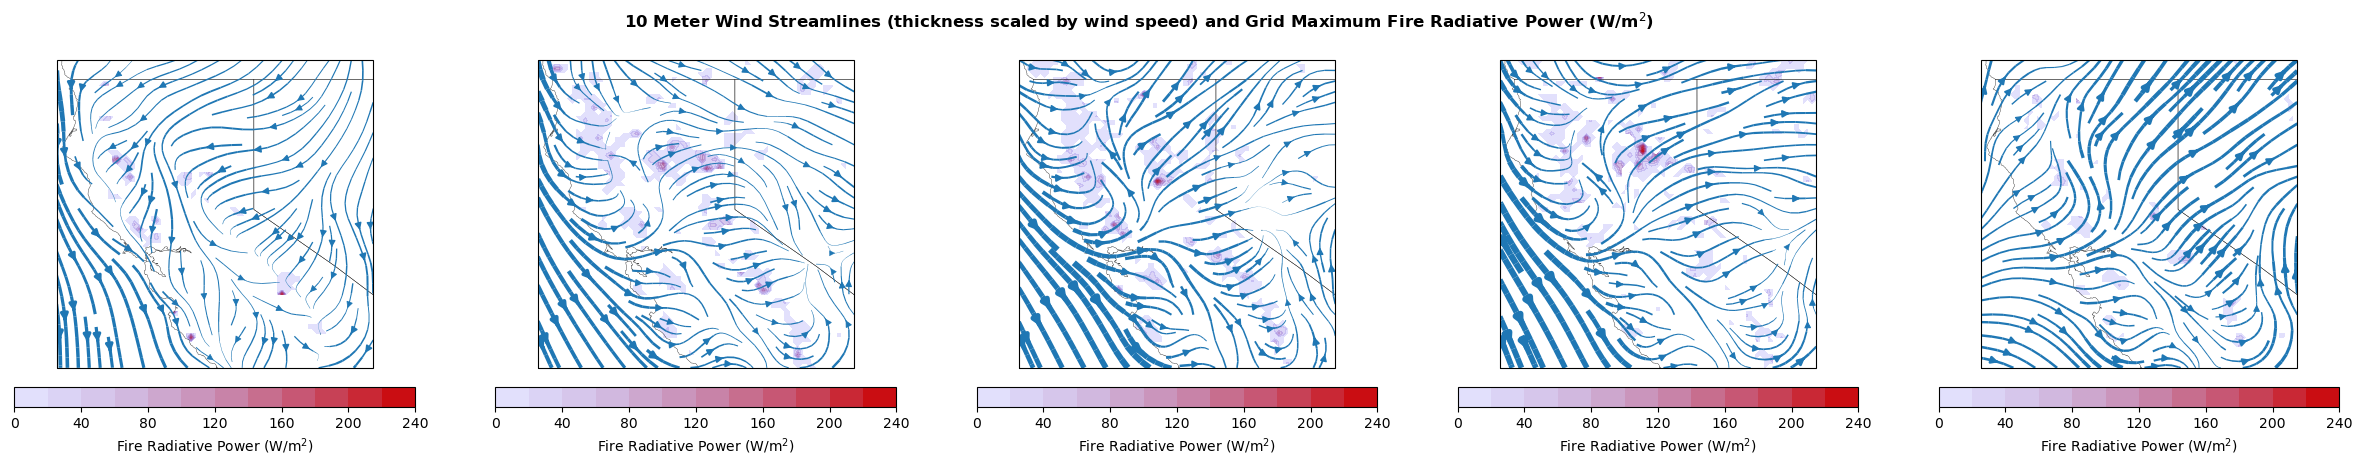

In [102]:
fig = plt.figure(figsize=(30, 5))
for i, cluster in enumerate(clusters['k']):
    k = i + 1

    u10_avg = np.mean(cluster['full']['u10'], axis=0)
    v10_avg = np.mean(cluster['full']['v10'], axis=0)
    wnd_avg = np.sqrt(u10_avg**2 + v10_avg**2)
    frp_max = np.max(cluster['frp'], axis=0)
    frp_max[frp_max == 0] = np.nan 

    ax = plt.subplot(1, 5, k, projection=ccrs.PlateCarree())
    ax.axis('scaled')
    ax.set_extent(norcal_domain, crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces', scale='10m'), linewidth=0.25, facecolor='none', edgecolor='black', zorder=2)

    frp_plt = plt.contourf(lonlon_frp, latlat_frp, frp_max, range(minfrp, maxfrp+1, 20), transform=ccrs.PlateCarree(), cmap=frp_cmap)
    cb = fig.colorbar(frp_plt, ticks=range(minfrp, maxfrp+1, 40), orientation='horizontal', pad=0.05)
    cb.set_label("Fire Radiative Power (W/m$^2$)")

    lw = 5*wnd_avg / wnd_avg.max()
    plt.streamplot(lonlon_syn, latlat_syn, u10_avg, v10_avg, linewidth=lw.values, density=1)

plt.suptitle("10 Meter Wind Streamlines (thickness scaled by wind speed) and Grid Maximum Fire Radiative Power (W/m$^2$)", weight='bold')

Text(0.5, 1.0, 'Fire Radiative Power Relationship to Mean Northern California Domain Temperature')

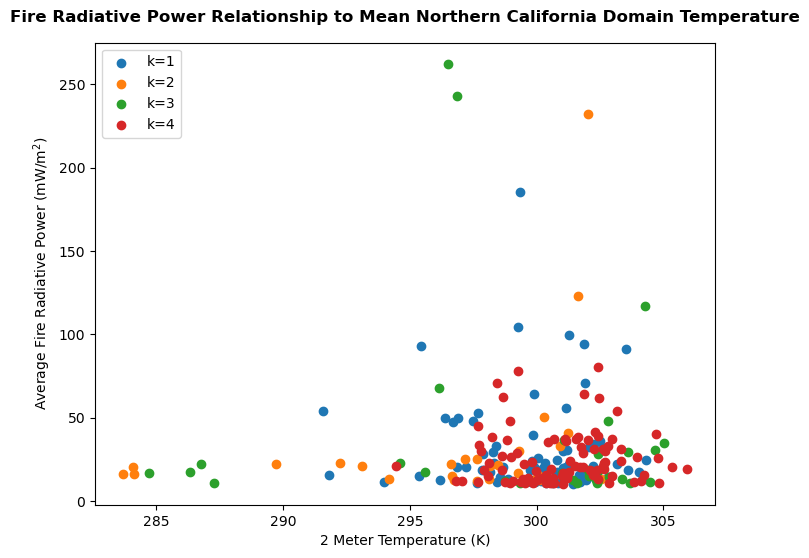

In [79]:
fig = plt.figure(figsize=(8,6))
for i, cluster in enumerate(clusters['k']):
    k = i + 1
    
    norcal_temps = cluster["full"]["t2m"].sel(latitude=slice(norcal_domain[3],norcal_domain[2]))
    norcal_temps = norcal_temps.sel(longitude=slice(norcal_domain[0], norcal_domain[1]))
    lonlon_t, latlat_t = np.meshgrid(norcal_temps.coords['longitude'].values, norcal_temps.coords['latitude'].values)
    sa_t = cu.sphere_surface_area(latlat_t, lonlon_t, 0.25)
    mean_temps = np.sum(norcal_temps.values * sa_t, axis=(1,2))/np.sum(sa_t, axis=(0,1))
    
    plt.scatter(mean_temps, cluster['area_average_frp']*1000, label=f"k={k}")
plt.legend(loc='upper left')
plt.xlabel("2 Meter Temperature (K)")
plt.ylabel("Average Fire Radiative Power (mW/m$^2$)")
plt.title("Fire Radiative Power Relationship to Mean Northern California Domain Temperature", pad=15, weight='bold')


In [14]:
cluster['area_average_frp']

array([0.01595141, 0.01595141, 0.02263501, 0.02213416, 0.0133382 ,
       0.0218269 , 0.02131435, 0.02252168, 0.02549468, 0.0168726 ,
       0.01335499, 0.01273128, 0.03030177, 0.01294734, 0.01345902,
       0.12320085, 0.02024708, 0.02530854, 0.02125354, 0.01196555,
       0.01503797])